# Imports :

In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import pickle
import requests

from tensorflow.keras.initializers import TruncatedNormal, RandomNormal
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, UpSampling2D
from tensorflow.keras.layers import Dropout, Conv2DTranspose, AveragePooling2D, add, Concatenate
from tensorflow.keras.utils import Progbar, plot_model

print('imported')

imported


## Utils :

In [2]:
def load_data(data_path):
    images = []
    filenames = os.listdir(data_path)
    for file in filenames:
        img = cv2.imread(data_path + file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return np.array(images)

def sample_date(batch_size, src, tar):
    idx = np.random.randint(0, src.shape[0], batch_size)
    s, t = norm_img(src[idx]), norm_img(tar[idx])
    return s, t

def show_sample(batch, x, y):
    plt.figure(figsize=(6,6))
    indx = np.random.choice(batch.shape[0], x * y, replace=False)
    for i in range(0, x * y):
        plt.subplot(x, y, i + 1)
        image = batch[indx[i]]
        fig = plt.imshow(image)
        plt.axis('off')
    plt.show()

def norm_img(img):
    img = (img / 127.5) - 1
    return img.astype('float32')

def denorm_img(img):
    img = (img + 1) * 127.5
    return img.astype('uint8')

## Data Path :

In [3]:
np.random.seed(33)
src_path = 'data/src/'
tar_path = 'data/tar/'
filenames = os.listdir(src_path)
print('{} files found.'.format(len(filenames)))

3228 files found.


# Collecting data :
Only execute when want to generate data

In [21]:
url_base = [
    "https://server.arcgisonline.com/arcgis/rest/services/Elevation/World_Hillshade/MapServer/tile/13/",
    "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/13/"
]

base_x = 2915
base_y = 1486

max_x = 200
max_y = 200

pas_x = 4
pas_y = 4

if not os.path.exists("data2/src"):
    os.makedirs("data2/src")
if not os.path.exists("data2/tar"):
    os.makedirs("data2/tar")

counter = 1738
for x in range(0, max_x, pas_x):
    for y in range(0, max_y, pas_y):
        req = requests.get(url_base[0]+"/"+str(base_x+x)+"/"+str(base_y+y))
        with open("data2/tar/tar{}.png".format(counter), "wb+") as f:
            f.write(req.content)
        req = requests.get(url_base[1]+"/"+str(base_x+x)+"/"+str(base_y+y))
        with open("data2/src/src{}.png".format(counter), "wb+") as f:
            f.write(req.content)
        counter = counter + 1

KeyboardInterrupt: 

In [4]:
src, tar = load_data(src_path), load_data(tar_path)

### Example :

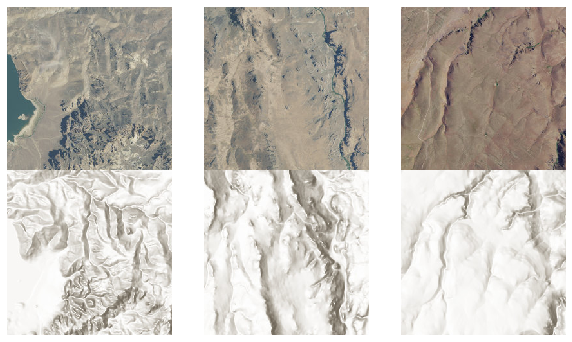

In [5]:
plt.figure(figsize=(10, 10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(np.vstack([src[25 + i], tar[25 + i]]))
    plt.axis('off')
plt.show()

# Pix2Pix Model :

In [6]:
class Pix2Pix():
    def __init__(self, discrminator_path=None, generator_path=None):
        self.data_shape = (256, 256, 3)
        
        if discrminator_path:
            self.discriminator = load_model(discrminator_path)
        else:    
            self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5),
                                  loss_weights=[0.5])
        
        if generator_path:
            self.generator = load_model(generator_path)
        else:
            self.generator = self.build_generator()
        self.discriminator.trainable = False
        combined_input = Input(shape=self.data_shape)
        gen_output = self.generator(combined_input)
        dis_output = self.discriminator([combined_input, gen_output])
        self.combined = Model(combined_input, [dis_output, gen_output])
        
        self.combined.compile(loss=['binary_crossentropy', 'mae'], optimizer=Adam(0.0002, 0.5),
                            loss_weights=[1, 100])
        
    
    def build_discriminator(self):
        init = RandomNormal(stddev=0.02)
        src_disc_input = Input(shape=self.data_shape)
        target_disc_input = Input(shape=self.data_shape)
        
        merged = Concatenate()([src_disc_input, target_disc_input])
        
        X = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(merged)
        X = LeakyReLU(alpha=0.2)(X)
        
        X = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(X)
        X = BatchNormalization()(X)
        X = LeakyReLU(alpha=0.2)(X)
    
        X = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(X)
        X = BatchNormalization()(X)
        X = LeakyReLU(alpha=0.2)(X)

        X = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(X)
        X = BatchNormalization()(X)
        X = LeakyReLU(alpha=0.2)(X)

        X = Conv2D(512, (4, 4), padding='same', kernel_initializer=init)(X)
        X = BatchNormalization()(X)
        X = LeakyReLU(alpha=0.2)(X)
        
        X = Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(X)
        X = Activation('sigmoid')(X)
        
        discriminator = Model([src_disc_input, target_disc_input], X, name='discriminator')
        return discriminator
    
    def downsample_block(self, link, filters, norm=True):
        X = Conv2D(filters, (4, 4), (2, 2), padding='same', kernel_initializer=RandomNormal(stddev=0.02),
                  use_bias=(not norm))(link)
        if norm:
            X = BatchNormalization()(X)
        X = LeakyReLU(0.2)(X)
        return X
    
    def upsample_block(self, link, skip, filters, drop=True):
        X = Conv2DTranspose(filters, (4, 4), (2, 2), padding='same', kernel_initializer=RandomNormal(0.02),
                           use_bias=False)(link)
        X = BatchNormalization(momentum=0.9)(X)
        if drop:
            X = Dropout(0.5)(X)
        X = Concatenate()([X, skip])
        X = LeakyReLU(0.2)(X)
        return X
    
    def build_generator(self):
        encoder_input = Input(shape=self.data_shape)
        
        X1 = self.downsample_block(encoder_input, 64, norm=False)
        X2 = self.downsample_block(X1, 128)
        X3 = self.downsample_block(X2, 256)
        X4 = self.downsample_block(X3, 512)
        X5 = self.downsample_block(X4, 512)
        X6 = self.downsample_block(X5, 512)
        X7 = self.downsample_block(X6, 512)
        
        X = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(0.02))(X7)
        X = Activation('relu')(X)
        
        X = self.upsample_block(X, X7, 512)
        X = self.upsample_block(X, X6, 512)
        X = self.upsample_block(X, X5, 512)
        X = self.upsample_block(X, X4, 512, drop=False)
        X = self.upsample_block(X, X3, 256, drop=False)
        X = self.upsample_block(X, X2, 128, drop=False)
        X = self.upsample_block(X, X1, 64, drop=False)
        
        X = Conv2DTranspose(3, (4, 4), (2, 2), padding='same', kernel_initializer=RandomNormal(0.02))(X)
        X = Activation('tanh')(X)
        
        generator = Model(encoder_input, X, name='generator')
        return generator
    
    def train(self, sources, targets, epochs=50, step=100, batch_size=1, save_at=2):
        d_output = self.discriminator.output_shape[1]
        progbar = Progbar(step)
        total_d_loss_real = []
        total_d_loss_fake = []
        total_g_loss = []
        
        stats = []
        
        for epoch in range(1, epochs + 1):
            for i in range(step):
                progbar.update(i + 1)
                
                real_s, real_t = sample_date(batch_size, src, tar)
                real_labels = np.ones((batch_size, d_output, d_output, 1))
                
                fake_s = self.generator.predict(real_s)
                fake_labels = np.zeros((batch_size, d_output, d_output, 1))
                
                d_loss_real = self.discriminator.train_on_batch([real_s, real_t], real_labels)
                d_loss_fake = self.discriminator.train_on_batch([real_s, fake_s], fake_labels)
                g_loss, _, _ = self.combined.train_on_batch(real_s, [real_labels, real_t])
                
                total_d_loss_fake.append(d_loss_fake)
                total_d_loss_real.append(d_loss_real)
                total_g_loss.append(g_loss)
                
                stats.append((d_loss_fake, d_loss_real, g_loss))
                
            print('Epoch %d : Real discriminator loss : %f --- Fake discriminator loss : %f --- Generator loss : %f'
                 % (epoch, np.mean(total_d_loss_real), np.mean(total_d_loss_fake), np.mean(total_g_loss)))
            test_sample = denorm_img(self.generator.predict(real_s))
            show_sample(test_sample, 1, 1)
            total_d_loss_fake.clear()
            total_d_loss_real.clear()
            total_g_loss.clear()
            
            if epoch % 10 == 0:
                self.discriminator.save('discriminator_model.h5')
                self.generator.save('generator_model.h5')
                print('models saved')
                with open('stats {}.pickle'.format(epoch), 'wb') as f:
                    pickle.dump(stats, f)
                print('stats saved')
        
    def summary(self):
        self.discriminator.summary()
        self.generator.summary()
        self.combined.summary()
        

# Training :

In [7]:
#src, tar = norm_img(src), norm_img(tar)
p2p = Pix2Pix(discrminator_path='discriminator_model.h5', generator_path='generator_model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100/100 [==============================] - 47s 468ms/step
Epoch 1 : Real discriminator loss : 0.112404 --- Fake discriminator loss : 2.894979 --- Generator loss : 2.257452


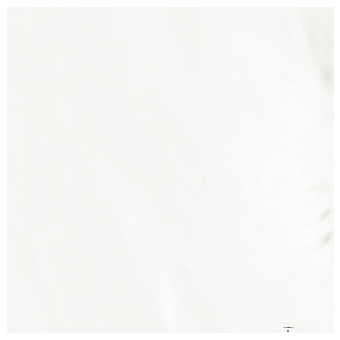

100/100 [==============================] - 82s 821ms/step
Epoch 2 : Real discriminator loss : 0.155194 --- Fake discriminator loss : 3.038966 --- Generator loss : 2.154595


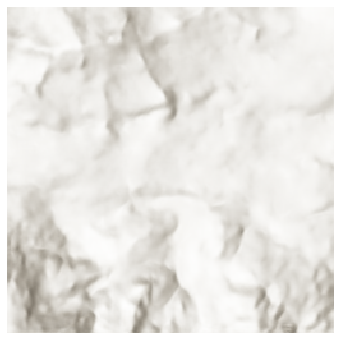

100/100 [==============================] - 118s 1s/step
Epoch 3 : Real discriminator loss : 0.090516 --- Fake discriminator loss : 3.156150 --- Generator loss : 2.352979


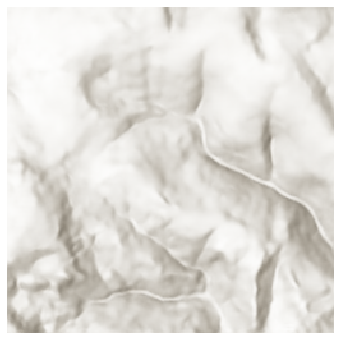

100/100 [==============================] - 153s 2s/step
Epoch 4 : Real discriminator loss : 0.101363 --- Fake discriminator loss : 3.013645 --- Generator loss : 2.308203


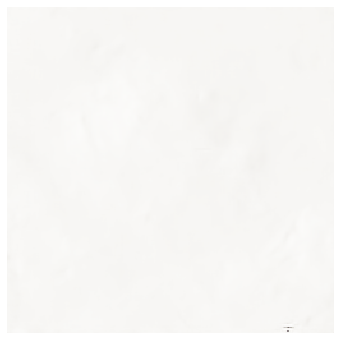

100/100 [==============================] - 189s 2s/step
Epoch 5 : Real discriminator loss : 0.095186 --- Fake discriminator loss : 3.071508 --- Generator loss : 2.322949


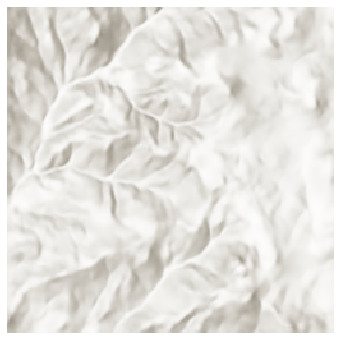

100/100 [==============================] - 225s 2s/step
Epoch 6 : Real discriminator loss : 0.103446 --- Fake discriminator loss : 3.126596 --- Generator loss : 2.512231


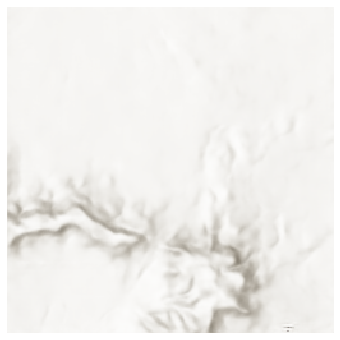

100/100 [==============================] - 260s 3s/step
Epoch 7 : Real discriminator loss : 0.149515 --- Fake discriminator loss : 2.734853 --- Generator loss : 2.485238


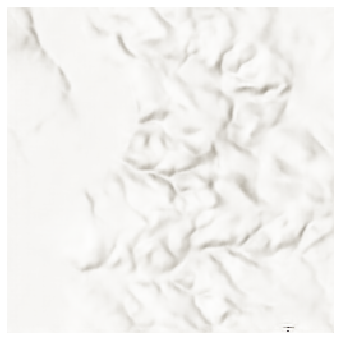

100/100 [==============================] - 296s 3s/step
Epoch 8 : Real discriminator loss : 0.088537 --- Fake discriminator loss : 3.182548 --- Generator loss : 2.337985


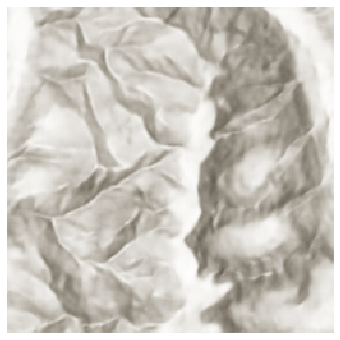

100/100 [==============================] - 332s 3s/step
Epoch 9 : Real discriminator loss : 0.078056 --- Fake discriminator loss : 3.237221 --- Generator loss : 2.521583


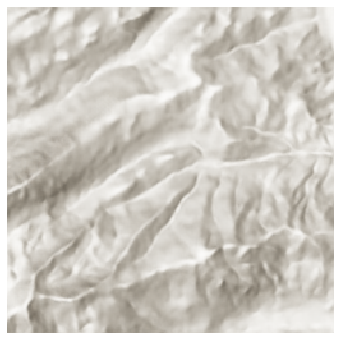

100/100 [==============================] - 368s 4s/step
Epoch 10 : Real discriminator loss : 0.062614 --- Fake discriminator loss : 3.248464 --- Generator loss : 2.488511


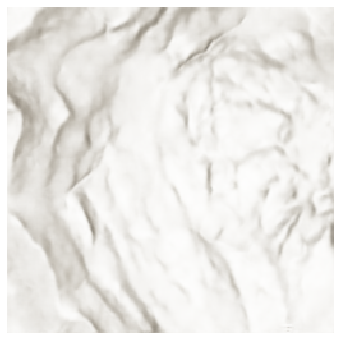

models saved
stats saved
100/100 [==============================] - 410s 4s/step
Epoch 11 : Real discriminator loss : 0.083567 --- Fake discriminator loss : 3.044320 --- Generator loss : 2.348114


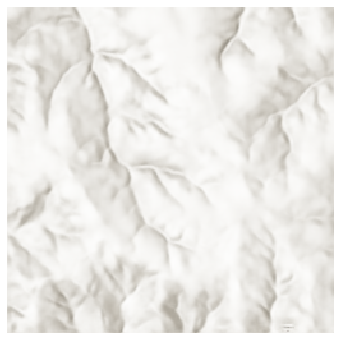

100/100 [==============================] - 445s 4s/step
Epoch 12 : Real discriminator loss : 0.093733 --- Fake discriminator loss : 3.067330 --- Generator loss : 2.447974


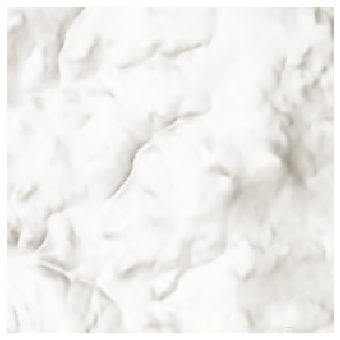

100/100 [==============================] - 481s 5s/step
Epoch 13 : Real discriminator loss : 0.070330 --- Fake discriminator loss : 3.128576 --- Generator loss : 2.450110


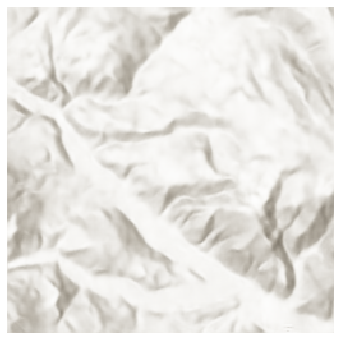

 94/100 [===========================>..] - ETA: 32s

In [ ]:
p2p.train(src, tar, batch_size=2, epochs=1000)

## Saving model :

In [9]:
p2p.discriminator.save('discriminator_model.h5')
p2p.generator.save('generator_model.h5')

### Clearing GPU memory :

In [22]:
from numba import cuda
cuda.select_device(0)
cuda.close()

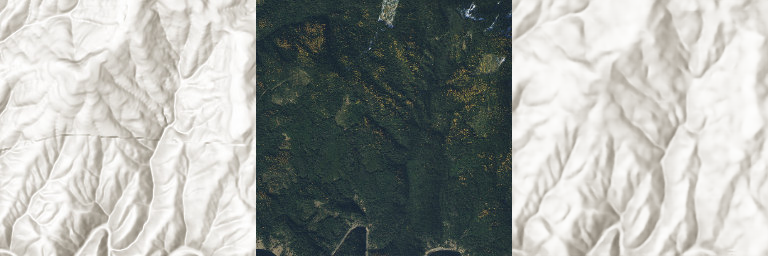

In [16]:
src_test = np.array(Image.open('data/src/src80.png'))
tar_test = np.array(Image.open('data/tar/tar80.png'))
predicted = p2p.generator.predict(np.expand_dims(norm_img(src_test), axis=0))
output = denorm_img(np.squeeze(predicted))
result = np.hstack([tar_test, src_test, output])
Image.fromarray(result)

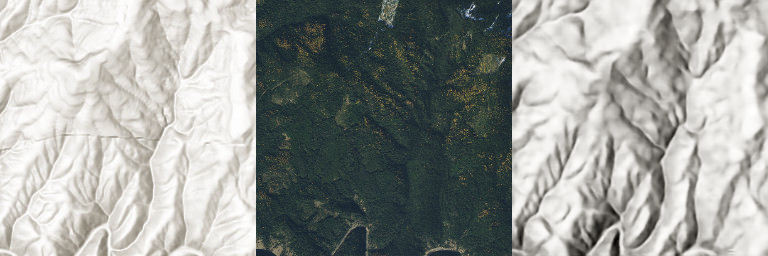

In [18]:
from skimage import exposure

#p2, p98 = np.percentile(output, (1, 90))
img_eq = exposure.equalize_adapthist(output, clip_limit=0.00001)
img_eq = (img_eq * 255).astype('uint8')
Image.fromarray(np.hstack([tar_test, src_test, img_eq]))